# スパースガウス過程でロジスティック回帰をminibatchでやるための試作

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../lib")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from scipy.spatial import distance_matrix
from scipy.stats import wishart

from util import logcosh, ratio_tanh_x

## 学習設定

In [4]:
data_seed = 20190908
n = 10000
sub_n = 400
M = 1
domain_X = (-10, 10)

true_func = lambda x: (x * np.sin(x)).sum(axis = 1)

## データ生成

In [5]:
np.random.seed(data_seed)

train_X = np.random.uniform(low = domain_X[0], high = domain_X[1], size = (n, M))
train_func = true_func(train_X)
train_prob = expit(train_func)
train_Y = np.random.binomial(n = 1, p = train_prob, size = n)

# バッチ処理による学習開始

## 学習設定

In [6]:
learning_seed = 20190909

iteration = 1000
theta1 = 1; theta2 = 1; theta3 = 0.0001
kronecker_delta = lambda x,y: np.exp(-distance_matrix(x,y)**2/(0.00001))
gauss_kernel = lambda x,y: theta1 * np.exp(-distance_matrix(x,y)**2/(theta2)) + theta3 * kronecker_delta(x,y)
gauss_kernel_diag = lambda x: theta1 * np.ones(len(x))  + theta3

used_kernel = gauss_kernel
used_kernel_diag = gauss_kernel_diag

step = 0.5
tol = 1e-7

## 部分データの選択

In [7]:
np.random.seed(learning_seed)
sub_train_X = np.random.uniform(low = domain_X[0], high = domain_X[1], size = (sub_n, M))
# sub_ind = np.random.permutation(n)[:sub_n]
# sub_train_X = train_X[sub_ind,:]

## 学習前の事前計算

In [8]:
## 学習で用いるカーネルの計算
sub_sub_kernel = used_kernel(sub_train_X, sub_train_X)
inv_sub_sub_kernel = np.linalg.inv(sub_sub_kernel)
train_sub_kernel = used_kernel(train_X, sub_train_X)

## 事後分布の形状パラメータの初期化
est_u = np.random.normal(size = sub_n)
est_Sigma = wishart.rvs(df = sub_n + 2, scale = np.eye(sub_n), size = 1)
# est_g_xi = np.random.normal(size = n)
est_h_xi = np.abs(np.random.normal(size = n))
nu1 = np.linalg.solve(est_Sigma, est_u)
nu2 = -np.linalg.inv(est_Sigma)/2

## メインの学習部分

In [9]:
a = train_sub_kernel @ inv_sub_sub_kernel
est_var_fu = used_kernel_diag(train_X) - ((train_sub_kernel @ inv_sub_sub_kernel) * train_sub_kernel).sum(axis = 1)

In [10]:
current_F = np.inf
for ite in range(iteration):
    ## 補助変数のを計算用に変換する
    est_sq_h_xi = np.sqrt(est_h_xi)
    est_v_xi = -ratio_tanh_x(est_sq_h_xi/2)/8
    
    ## 事後分布の形状パラメータの計算
    b = np.sqrt(-est_v_xi.repeat(sub_n).reshape((n, sub_n)))*a
    dFdnu1 = -(train_Y - 0.5) @ a + nu1
    dFdnu2 = b.T @ b + inv_sub_sub_kernel/2 + nu2
    nu1 += -step * dFdnu1
    nu2 += -step * dFdnu2
    
    ## 補助変数の計算 -> もともとのものにlogを付けた変数の最適化を行っている
    est_Sigma = -np.linalg.inv(nu2)/2
    est_u = -np.linalg.solve(nu2, nu1)/2
    m2_u = est_Sigma + est_u.reshape((sub_n, 1)) @ est_u.reshape((1, sub_n))
    est_h_xi = est_var_fu + ((a @ m2_u) * a).sum(axis = 1)
    ### エネルギーの計算
    est_sq_h_xi = np.sqrt(est_h_xi)
    est_v_xi = -ratio_tanh_x(est_sq_h_xi/2)/8
    phi_h = (-logcosh(est_sq_h_xi/2)-np.log(2)).sum()
    F = 0
    F += -phi_h + est_v_xi @ est_h_xi
    F += -(train_Y - 0.5) @ a @ est_u - est_v_xi @ (est_var_fu + ((a @ m2_u)*a).sum(axis=1))
    F += (np.trace(inv_sub_sub_kernel @ est_Sigma) + est_u @ inv_sub_sub_kernel @ est_u - sub_n + np.linalg.slogdet(sub_sub_kernel)[1] -  np.linalg.slogdet(est_Sigma)[1])/2
    
    print(F, np.sqrt((dFdnu1**2).mean()), np.sqrt((dFdnu2**2).mean()))
    
    if np.abs(F - current_F) < tol:
        break
    current_F = F
    
    pass

3723.2191079104214 13.470216498838873 2591.9340914038585
3513.350648963252 6.735108249419437 1295.954474134379
3428.154975186343 3.3675541247097183 647.9727833430594
3378.435464822409 1.6837770623548591 323.9833968918759
3345.5501740866093 0.8418885311774297 161.98939380693832
3322.469882317617 0.4209442655887149 80.9928482059486
3305.6284872297833 0.2104721327943574 40.49491900521174
3292.967519943444 0.1052360663971788 20.246222577780948
3283.2194833509843 0.05261803319858937 10.122085460854214
3275.566779276406 0.02630901659929455 5.060184176774532
3269.4612163927764 0.01315450829964727 2.529367242455118
3264.52315098173 0.006577254149823651 1.2640667126242933
3260.482479515592 0.0032886270749118516 0.6315044610316478
3257.1426155837353 0.0016443135374560555 0.31529581368587184
3254.3576602560834 0.0008221567687280289 0.1572517718657247
3252.017469184793 0.00041107838436402346 0.07828043812179734
3250.037622800601 0.00020553919218199045 0.03883797881353285
3248.3525359401983 0.00010

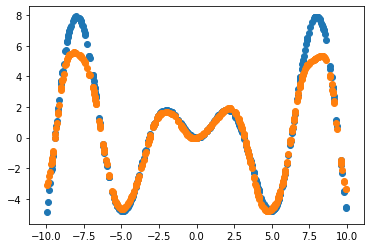

In [11]:
plt.scatter(sub_train_X[:,0], true_func(sub_train_X))
plt.scatter(sub_train_X[:,0], est_u)
plt.show()

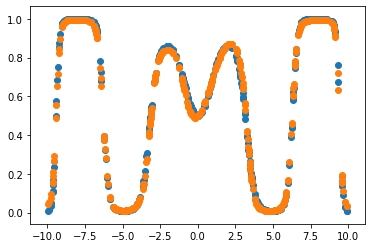

In [12]:
plt.scatter(sub_train_X[:,0], expit(true_func(sub_train_X)))
plt.scatter(sub_train_X[:,0], expit(est_u))
plt.show()

# ミニバッチ処理による学習開始

## 学習設定

In [13]:
learning_seed = 20190909

iteration = 1000
theta1 = 1; theta2 = 1; theta3 = 0.0001
kronecker_delta = lambda x,y: np.exp(-distance_matrix(x,y)**2/(0.00001))
gauss_kernel = lambda x,y: theta1 * np.exp(-distance_matrix(x,y)**2/(theta2)) + theta3 * kronecker_delta(x,y)
gauss_kernel_diag = lambda x: theta1 * np.ones(len(x))  + theta3

used_kernel = gauss_kernel
used_kernel_diag = gauss_kernel_diag

alpha = 0.5
tol = 1e-7

max_minibatch_size = 1000
epoch_num = 50

## 部分データの選択

In [14]:
np.random.seed(learning_seed)
sub_train_X = np.random.uniform(low = domain_X[0], high = domain_X[1], size = (sub_n, M))
# sub_ind = np.random.permutation(n)[:sub_n]
# sub_train_X = train_X[sub_ind,:]

## 学習前の事前計算

In [20]:
## 学習で用いるカーネルの計算
sub_sub_kernel = used_kernel(sub_train_X, sub_train_X)
inv_sub_sub_kernel = np.linalg.inv(sub_sub_kernel)

## 事後分布の形状パラメータの初期化
est_u = np.random.normal(size = sub_n)
est_Sigma = wishart.rvs(df = sub_n + 2, scale = np.eye(sub_n), size = 1)
# est_g_xi = np.random.normal(size = n)
est_h_xi = np.abs(np.random.normal(size = n))
nu1 = np.linalg.solve(est_Sigma, est_u)
nu2 = -np.linalg.inv(est_Sigma)/2

## メインの学習部分

In [21]:
minibatch_num = int(np.ceil(n / max_minibatch_size))

In [22]:
total_ite = 0
for ite_epoch in range(epoch_num):
    current_perm = np.random.permutation(n)
    for minibatch_ite in range(minibatch_num):
        picked_ind = current_perm[(minibatch_ite*max_minibatch_size):((minibatch_ite+1)*max_minibatch_size)] if minibatch_ite < minibatch_num-1 else current_perm[(minibatch_ite*max_minibatch_size):]
        current_train_X = train_X[picked_ind,:]
        current_train_Y = train_Y[picked_ind]
        minibatch_size = len(picked_ind)
        
        train_sub_kernel = used_kernel(current_train_X, sub_train_X)
        a = train_sub_kernel @ inv_sub_sub_kernel
        est_var_fu = used_kernel_diag(current_train_X) - ((train_sub_kernel @ inv_sub_sub_kernel) * train_sub_kernel).sum(axis = 1)
        
        ## 補助変数の計算 -> もともとのものにlogを付けた変数の最適化を行っている
        est_Sigma = -np.linalg.inv(nu2)/2
        est_u = -np.linalg.solve(nu2, nu1)/2
        m2_u = est_Sigma + est_u.reshape((sub_n, 1)) @ est_u.reshape((1, sub_n))
        current_h_xi = est_var_fu + ((a @ m2_u) * a).sum(axis = 1)
        est_h_xi[picked_ind] = current_h_xi                
        
        ## 補助変数を計算用に変換する
        current_h_xi = est_h_xi[picked_ind]
        est_sq_h_xi = np.sqrt(current_h_xi)
        est_v_xi = -ratio_tanh_x(est_sq_h_xi/2)/8

        ## 事後分布の形状パラメータの計算
        b = np.sqrt(-est_v_xi.repeat(sub_n).reshape((minibatch_size, sub_n)))*a
        dFdnu1 = -(current_train_Y - 0.5) @ a + nu1
        dFdnu2 = b.T @ b + inv_sub_sub_kernel/2 + nu2
        nu1 += -alpha/(total_ite+1) * dFdnu1
        nu2 += -alpha/(total_ite+1) * dFdnu2
#         nu1 += -alpha * dFdnu1
#         nu2 += -alpha * dFdnu2
        
        ### エネルギーの計算
        est_sq_h_xi = np.sqrt(current_h_xi)
        est_v_xi = -ratio_tanh_x(est_sq_h_xi/2)/8
        phi_h = (-logcosh(est_sq_h_xi/2)-np.log(2)).sum()
        F = 0
        F += -phi_h + est_v_xi @ current_h_xi
        F += -(current_train_Y - 0.5) @ a @ est_u - est_v_xi @ (est_var_fu + ((a @ m2_u)*a).sum(axis=1))
        F += (np.trace(inv_sub_sub_kernel @ est_Sigma) + est_u @ inv_sub_sub_kernel @ est_u - sub_n + np.linalg.slogdet(sub_sub_kernel)[1] -  np.linalg.slogdet(est_Sigma)[1])/2

        pass
    print(F, np.sqrt((dFdnu1**2).mean()), np.sqrt((dFdnu2**2).mean()))
    pass

401.2032680245182 0.44315934820062985 5.069161201870863
374.29992623682705 0.46853836300209134 0.007035493244423523
386.2116148498101 0.45035563757559005 0.005771136968976063
360.2076664257598 0.5321161427600904 0.007980117785611371
395.5508238353792 0.46895391544828263 0.005059366205552681
392.8026649985534 0.4733451395708858 0.006841200674877482
445.3603369683122 0.4545756063508986 0.012784038925018107
392.25248503346126 0.4521727562114709 0.03281096617783149
394.5345632403882 0.6046344365787264 0.012196603109796726
382.2813629788218 0.40116821431795713 0.003412412071876162
391.53291091247604 0.44303971983971496 0.007679872484434697
364.17421383115936 0.5281021548804022 0.00758768037011913
389.15152026931133 0.43715285299042095 0.0035699161735967735
395.98141507332707 0.4666663073949233 0.005352686107010952
395.73357464666344 0.48966718025063033 0.006990609198950546
389.85764532067304 0.45067105344728625 0.008216522133263654
378.832438136207 0.454511667420355 0.006500238113212897
378

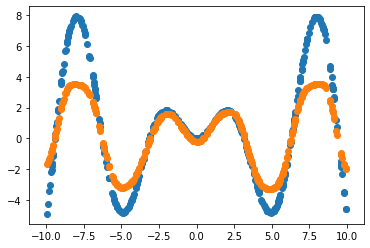

In [23]:
plt.scatter(sub_train_X[:,0], true_func(sub_train_X))
plt.scatter(sub_train_X[:,0], est_u)
plt.show()

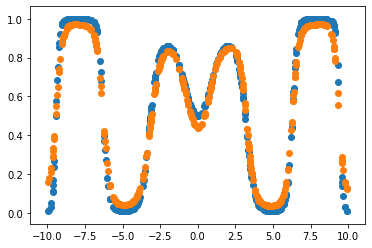

In [24]:
plt.scatter(sub_train_X[:,0], expit(true_func(sub_train_X)))
plt.scatter(sub_train_X[:,0], expit(est_u))
plt.show()